In [ ]:
#OPTIMISING GABOR FILTER PARAMS
#OPTIMISING PCA COMPONENT VALUES 

In [1]:
# PREPROCESSING/LOADING OF PRIOR DATASET
# Importing libraries 
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set image dimensions
IMG_SIZE = (128, 128)
train_dir = 'train'
test_dir = 'test'

# Print the current working directory to ensure we're working in the right path
print(f"Current working directory: {os.getcwd()}")

# Function to load and preprocess images
def load_images_from_directory(directory):
    images = []
    labels = []
    supported_extensions = ('.png', '.jpg', '.jpeg')

    for label_dir in os.listdir(directory):
        label_path = os.path.join(directory, label_dir)
        if not os.path.isdir(label_path):
            continue

        label = 1 if label_dir.lower() == "pneumonia" else 0  # 1 for pneumonia, 0 for normal

        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)

            # Only process supported image files and skip hidden files
            if img_file.lower().endswith(supported_extensions) and not img_file.startswith('.'):
                try:
                    # Load, resize, convert to grayscale, and normalize
                    img = Image.open(img_path).resize(IMG_SIZE).convert('L')
                    img_array = np.array(img) / 255.0  # Normalize
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Could not process {img_file}: {e}")
            else:
                print(f"Skipping unsupported file: {img_file}")

    return np.array(images), np.array(labels)

# Load and preprocess all images in the directory
X_train, y_train = load_images_from_directory(train_dir)
X_test, y_test = load_images_from_directory(test_dir)

Current working directory: C:\Users\rheam


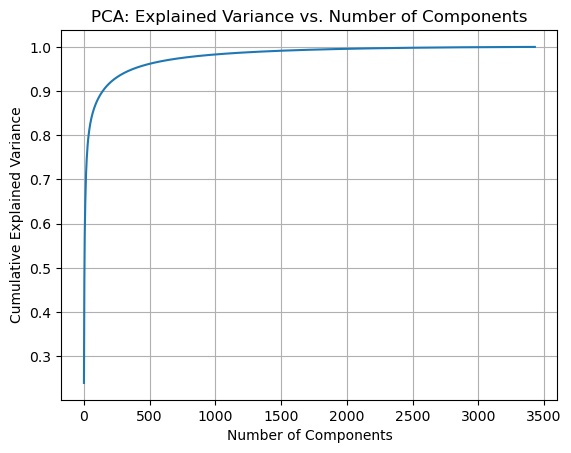

In [3]:
#FINDING OPTIMAL COMPONENTS FOR PCA
# Before applying PCA, flatten the images into 1D vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each image to a 1D array
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Apply PCA
pca = PCA().fit(X_train_flat)

# Plot the cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
# USING RANDOMISED SEARCH FOR GABOR OPTIMISATION

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
import cv2

#1. define the Gabor filter(create function) def_Gabor.....
#2. define a class, transformer to apply Gabor
#3. pipeline --> defining pipeline for each feature (Note, we have already found optimal values for PCA and KNN therefore fix these parameters)

#1
def apply_gabor_filter(img, ksize, sigma, theta, lambd, gamma, psi):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
    gabor_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
    return gabor_img

#2
class GaborTransformer:
    def __init__(self, ksize=11, sigma=4, theta=0, lambd=10, gamma=0.5, psi=0):
        self.ksize = ksize
        self.sigma = sigma
        self.theta = theta
        self.lambd = lambd
        self.gamma = gamma
        self.psi = psi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Apply the Gabor filter to each image in X and flatten the result
        return np.array([apply_gabor_filter(img, self.ksize, self.sigma, self.theta, self.lambd, self.gamma, self.psi).ravel() for img in X])

#3
pipeline = Pipeline([
    ('gabor', GaborTransformer(ksize=11, sigma=4, theta=0, lambd=10, gamma=0.5, psi=0)), # Gabor filter parameters
    ('pca', PCA(n_components=2000)),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])

# Evaluate pipeline performance
scores = cross_val_score(pipeline, X_train_flat, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(scores):.4f}")

Cross-validation accuracy: 0.9321
